# Template to Exercise 2

Author: Tobias Stollenwerk, Nil Rodellas Gràcia, Institute for Quantum Computing Analytics (PGI-12), FZ Jülich

Student: Haotian Wang

Matriculation Number: 421723

**Please use this template for exercise 2**

## Exercise 2.1

In [1]:
import qiskit
# numerics
import numpy as np
# functional programmin tools
import itertools
import functools
import operator
# plotting
import matplotlib.pyplot as plt
import seaborn
# data analysis
import pandas as pd
# qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator, AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Kraus, SuperOp, SparsePauliOp, Operator, DensityMatrix, Statevector
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error
from qiskit.circuit import ParameterVector

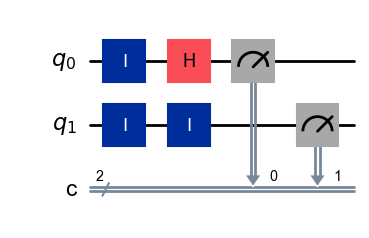

In [2]:
circuit = QuantumCircuit(2, 2)
circuit.id(0)
circuit.id(1)
circuit.h(0)
circuit.id(1)
circuit.measure(0, 0)
circuit.measure(1, 1);
# display the circuit
display(circuit.draw('mpl'))

In [3]:
p = 0.1

error_1 = depolarizing_error(p, 1)

In [4]:
p0given1 = 0.1
p1given0 = 0.05

error_readout = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

In [22]:
# ... build noise model here
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'h'])

sim_noise = AerSimulator(noise_model=noise_model)
circuit_with_noise = transpile(circuit, sim_noise)
result = sim_noise.run(circuit_with_noise).result()
print(result)
counts = result.get_counts(0)

print(counts)

Result(backend_name='aer_simulator', backend_version='0.17.0', job_id='83572c66-cba2-42e7-9a30-e16fa154c2ca', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 557, '0x1': 467}), header={'creg_sizes': [['c', 2]], 'global_phase': 0.7853981633974483, 'memory_slots': 2, 'n_qubits': 2, 'name': 'circuit-162', 'qreg_sizes': [['q', 2]], 'metadata': {}}, status=DONE, seed_simulator=3758413386, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'density_matrix', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0028444, 'sample_measure_time': 0.0002062, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 32548, 'measure_sampling': True, 'noise': 'superop', 'parallel_shots': 1, 'parallel_state_update': 20, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'threshold': 7, 'max_fused_qubits

### 2.1.(d) Simulate without readout error

{'00': 506, '01': 518}
{'01': 528, '00': 496}
{'01': 512, '00': 512}
{'00': 505, '01': 519}
{'00': 523, '01': 501}
{'00': 507, '01': 517}
{'01': 501, '00': 523}
{'01': 493, '00': 531}
{'00': 507, '01': 517}
{'01': 521, '00': 503}
{'01': 510, '00': 514}


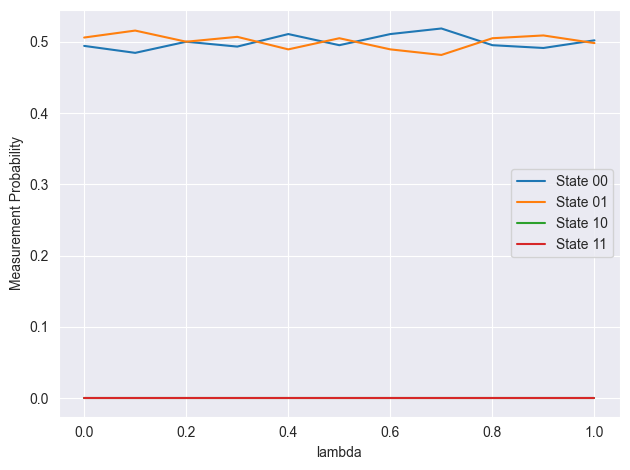

In [32]:


ps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# ps = np.linspace(0, 1, 100)
prob_results = {"00":[], "01":[], "10":[], "11":[]}
for p in ps:
    error_1 = depolarizing_error(p, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['id', 'h'])
    sim_noise = AerSimulator(noise_model=noise_model)
    circuit_with_noise = transpile(circuit, sim_noise)
    result = sim_noise.run(circuit_with_noise, total_shots = 1000).result()
    counts = result.get_counts()
    print(counts)
    total_shots = sum(counts.values())
    probs = {state: count / total_shots for state, count in counts.items()}
    for state in prob_results:
        if state in probs:
            prob_results[state].append(probs[state])
        else:
            prob_results[state].append(0.0)
            
for bitstring, prob_list in prob_results.items():
    plt.plot(ps, prob_list, label=f"State {bitstring}")

plt.xlabel("lambda")
plt.ylabel("Measurement Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
## The plot seems a bit weird, does not correspond to the analytical results.
    

### Exercise 2.2.(f) 
Simulate the circuit including readout error for $\lambda = \frac{1}{10}$, $p_a = \frac{1}{20}$, $p_b = \frac{1}{10}$

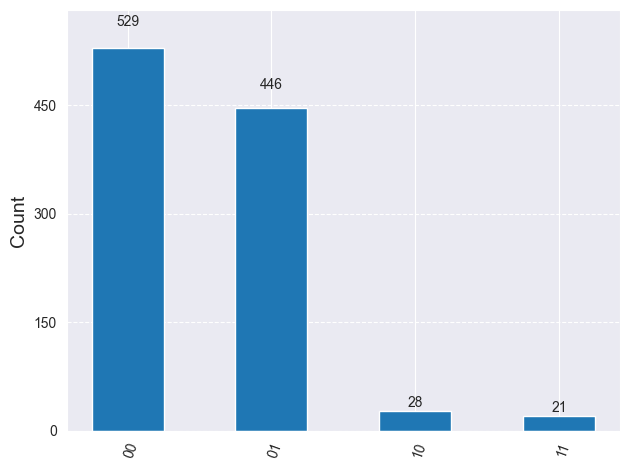

In [30]:
p = 0.1

error_1 = depolarizing_error(p, 1)

p_a = .05
p_b = .1
error_2 = ReadoutError([[1-p_a, p_a], [p_b, 1-p_b]])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'h'])

noise_model.add_all_qubit_readout_error(error_2)

sim = AerSimulator(noise_model=noise_model)
transpiled = transpile(circuit, sim)

result = sim.run(transpiled).result()
counts = result.get_counts()
plot_histogram(counts)


## Exercise 2.2 - quantum optimization
### Hints

Consider the MaxCut case

$$
H_f = \sum_{u, v \in E} Z_u Z_v
$$

for the edge set $E = \{(1, 2), (2, 3), (2, 4), (3, 4)\}$

In [40]:
# E = [(1, 2), (2, 3), (2, 4), (3, 4)]  
# V = [1, 2, 3, 4]
# 
# pauli_strings = []
# for u, v in E:
#     pauli_strings.append("".join(["I" if i not in (u, v) else "Z" for i in V ]))
# H = SparsePauliOp(pauli_strings) ## Is it just an idea of how to produce a pauli string?????
paulis = [
    "IIII",
    "ZIII",
    "IZII",
    "IIZI",
    "IIIZ",
    "ZZII",
    "ZIZI",
    "IZZI",
    "IZIZ",
]
coeffs = [
    4.5,
    -.5,
    .25,
    .5,
    .25,
    .25,
    .25,
    -.25,
    -.25
]

H = SparsePauliOp.from_list(list(zip(paulis, coeffs)))


In [41]:
basis_states = {}
ket = {0: Statevector([1, 0]), 1: Statevector([0, 1])}
for i, bitstring in enumerate(itertools.product([0, 1], repeat=4)):
    state = ket[bitstring[0]]
    for k in range(len(bitstring) - 1):
        state = state.tensor(ket[bitstring[k + 1]])
    basis_states[bitstring] = state
print(basis_states.keys())

dict_keys([(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)])


In [42]:
for bitstring, state in basis_states.items():
    f = state.expectation_value(H)
    print("<{}|H|{}> = {}".format(bitstring, bitstring, f))

<(0, 0, 0, 0)|H|(0, 0, 0, 0)> = (5+0j)
<(0, 0, 0, 1)|H|(0, 0, 0, 1)> = (5+0j)
<(0, 0, 1, 0)|H|(0, 0, 1, 0)> = (4+0j)
<(0, 0, 1, 1)|H|(0, 0, 1, 1)> = (4+0j)
<(0, 1, 0, 0)|H|(0, 1, 0, 0)> = (5+0j)
<(0, 1, 0, 1)|H|(0, 1, 0, 1)> = (4+0j)
<(0, 1, 1, 0)|H|(0, 1, 1, 0)> = (3+0j)
<(0, 1, 1, 1)|H|(0, 1, 1, 1)> = (2+0j)
<(1, 0, 0, 0)|H|(1, 0, 0, 0)> = (5+0j)
<(1, 0, 0, 1)|H|(1, 0, 0, 1)> = (5+0j)
<(1, 0, 1, 0)|H|(1, 0, 1, 0)> = (5+0j)
<(1, 0, 1, 1)|H|(1, 0, 1, 1)> = (5+0j)
<(1, 1, 0, 0)|H|(1, 1, 0, 0)> = (6+0j)
<(1, 1, 0, 1)|H|(1, 1, 0, 1)> = (5+0j)
<(1, 1, 1, 0)|H|(1, 1, 1, 0)> = (5+0j)
<(1, 1, 1, 1)|H|(1, 1, 1, 1)> = (4+0j)
